In [9]:
import os 
figure_folder = 'figure-current'
os.makedirs(figure_folder, exist_ok=True)

threshold = 3.5 
n_ms_per_s= 1000
n_total_trial= 100

curation = {
    'M15_2': {
        # 'CA1': (3.5, [1, 6, 7, 8, 9, 10, 11, 13, 15,16,20,21, 22, 23, 24, 29, 36, 44, 45, 48]),
        'CA1': (3.5, [1, 6, 7, 8, 9, 10, 11, 13, 15, 24, 29, 36, 44, 45, 48]),
        # Noisy 'M1': [], 
    }, 
    'M15_3': {
       'CA1': (3.5, [25, 29, 34]), 
        'M1': (3.5, [23, 24]), 

    }, 
    'M15_5': {
        'CA1': (3.5, [4, 5, 7, 8, 9, 10, 11, 12, 15, 21, 62, 66]),
        # 'M1': (3.5, [28, 29, 31, 33, 34,35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
        'M1': (3.5, [28, 29, 31, 33, 34,35, 36, 37, 38, 39, 40, 41, 43, 44]),
    }, 
    'M15_7': {
        'CA1': (3.5, [7, 11, 12, 13, 14, 19, 20]),
        # 'M1': (3.5, [4, 6, 10, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29, 30,31,  32,35, 36,  37, 38, 41, 42, 44, 45, 46, 47,48,  51, 52, 53, 55, 56, 57, 58,59,62]),
        'M1': (3.5, [4, 6, 10, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29, 30,31,  32,35, 37, 38, 41, 42, 44, 45, 46, 47,48,  51, 52, 53, 55, 56, 57, 58,59,62]),
    }, 
    'M16_1': {
        # 'CA1': (3.5, [1, 2,3,  4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 22, 25, 26, 27, 29, 31, 32, 33, 34, 35, 36, 37, 38, 54, 57, 58, 59, 60, 61, 62]),
        'CA1': (3.5, [1, 2,3,  4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 25, 26, 27, 29, 31, 32, 33, 35, 36, 37, 38, 54, 57, 58, 59, 60, 61, 62]),
        # Noisy 'M1': (), 
    },
}    

# Reaction Time

In [3]:
import glob 
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd 
import seaborn as sns

from statannotations.Annotator import Annotator


session_palette = {
    session_index + 1: color for session_index, color in enumerate(['#D1D9EC', '#a2b1d8', '#8597c6', '#697fb7', '#ffbcbb', '#ffb5b4', '#ffaeac', '#ffa6a5', '#e44e4b', '#d93f3c', '#cc3330', '#b03533', '#ddde29', '#bcbd21'])
}

joystick_length = 15
hw = 2048
n_s_per_min = 60
n_ms_per_s = 1000
joystick_threshold = 0.15
n_total_trial = 100

def analog_to_digital(analog, max_joystick_angle=22.5):
    return joystick_length * (np.sin(np.deg2rad(max_joystick_angle * analog/hw)))

reaction_times = []
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    session_paths = sorted(glob.glob(f'data/raw/controller/**/{subject.replace("_", "-")}.TXT'))

    for session_index, session_path in enumerate(session_paths):
        events = pd.read_csv(session_path)
        # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
        state_ids = np.where(events['state'] == 'state')[0]
        if len(state_ids) > 0:
            events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
            events['x'] = pd.to_numeric(events['x'])
            events['y'] = pd.to_numeric(events['y'])
            events['time'] = pd.to_numeric(events['time'])
            events['state'] = pd.to_numeric(events['state'])
            events['trial'] = pd.to_numeric(events['trial'])
            events['s_trial'] = pd.to_numeric(events['s_trial'])
            events['f_trial'] = pd.to_numeric(events['f_trial'])

        events['x'] = analog_to_digital(events['x'])
        events['y'] = analog_to_digital(events['y'])
        events['position'] = np.sqrt(events['x'] ** 2 + events['y'] ** 2)
        events['time'] = events['time'] - events['time'][0]
        events['time'] = events['time'] / n_ms_per_s 

        for trial in range(n_total_trial):
            trial_indices = np.where(events['trial'] == trial)[0]
            if any(events['state'][trial_indices] == 1):
                trial_reaction_index = np.where((events['trial'] == trial) & (events['state'] == 1))[0][0]
                reaction_times.append({
                    'subject': subject,
                    'session': session_index+1,
                    'reaction': events['time'][trial_reaction_index] - events['time'][trial_indices.min()],
                })
        
reaction_times = pd.DataFrame(reaction_times)

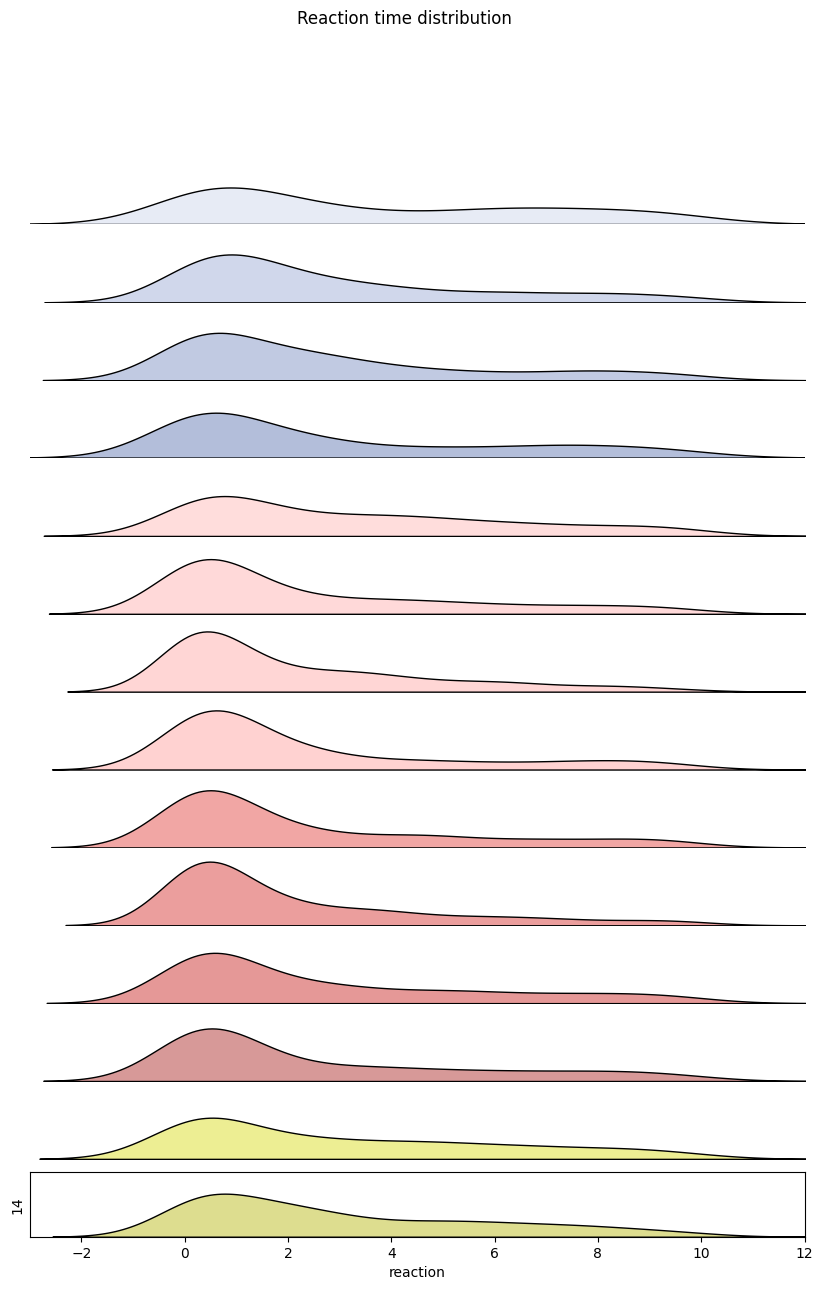

In [4]:
fig = plt.figure(figsize=(10, 15))
for session in range(1, reaction_times['session'].max()+1):
    ax = plt.subplot(len(reaction_times['session'].unique())+1, 1, session)
    sns.kdeplot(data=reaction_times[reaction_times['session']==session], x='reaction', label=f'Session {session+1}', ax=ax, fill=True, color=session_palette[session],edgecolor='black', alpha=0.5)
    ax.set_ylim(0, 0.28)
    ax.set_xlim(-3, 12)
    ax.set_ylabel(session)
    ax.set_yticks([])
    ax.set_axis_off()
ax.set_axis_on()
fig.suptitle(f'Reaction time distribution')
plt.savefig(f'{figure_folder}/reaction_density.pdf')
plt.show()
plt.close()

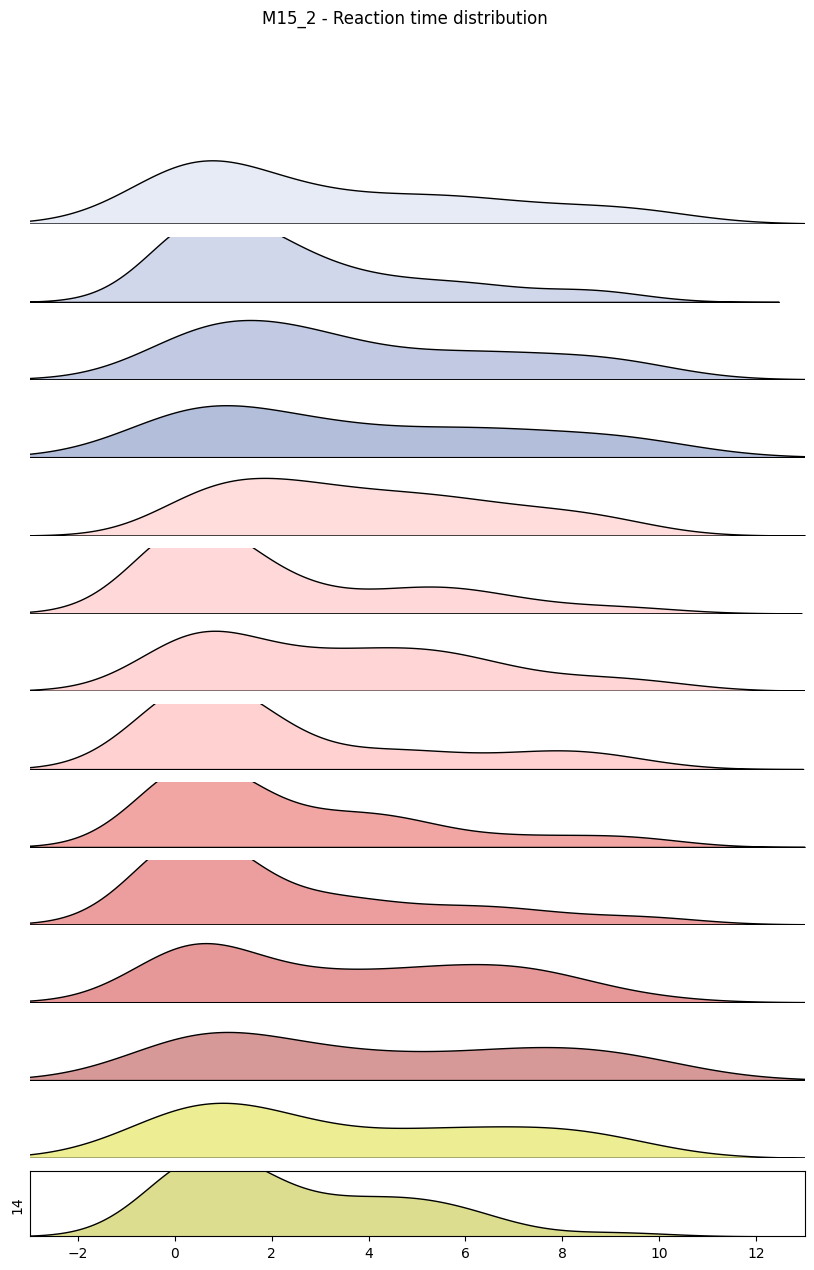

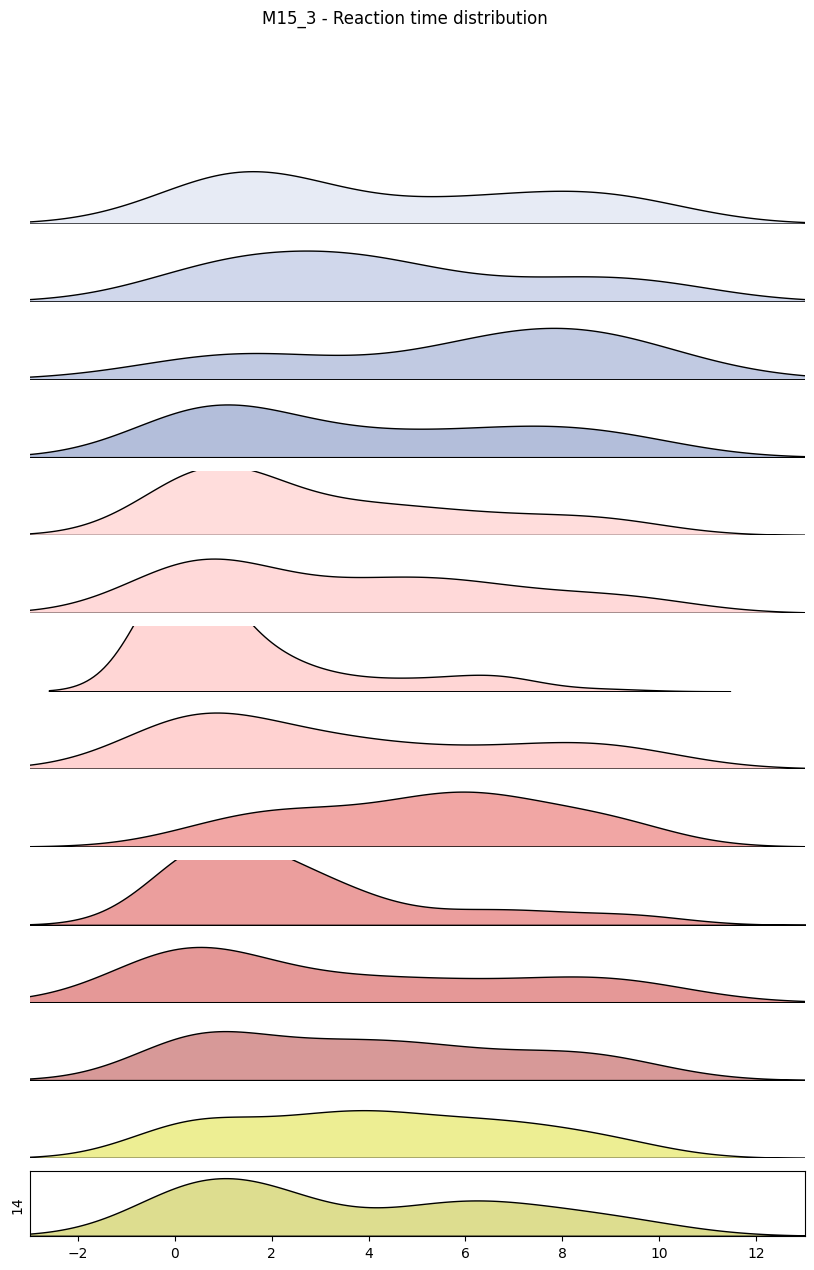

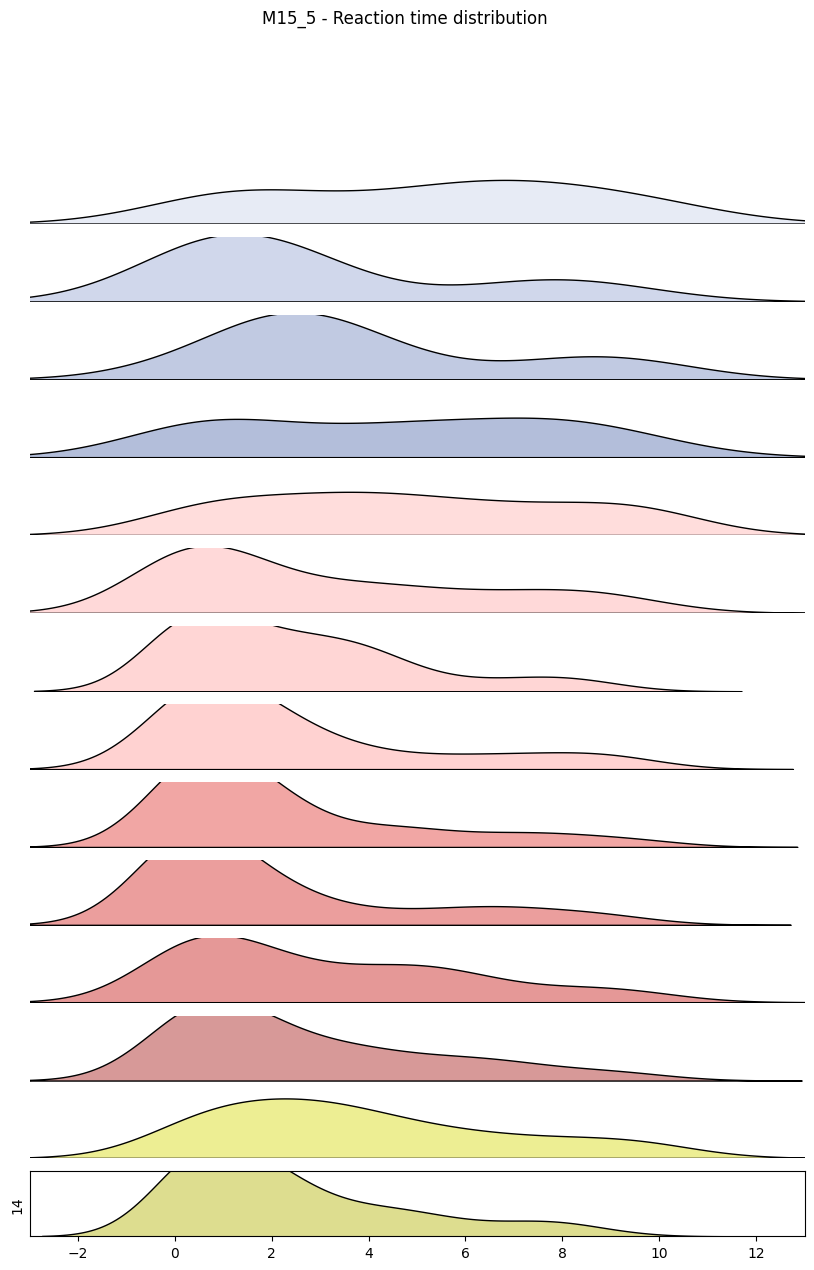

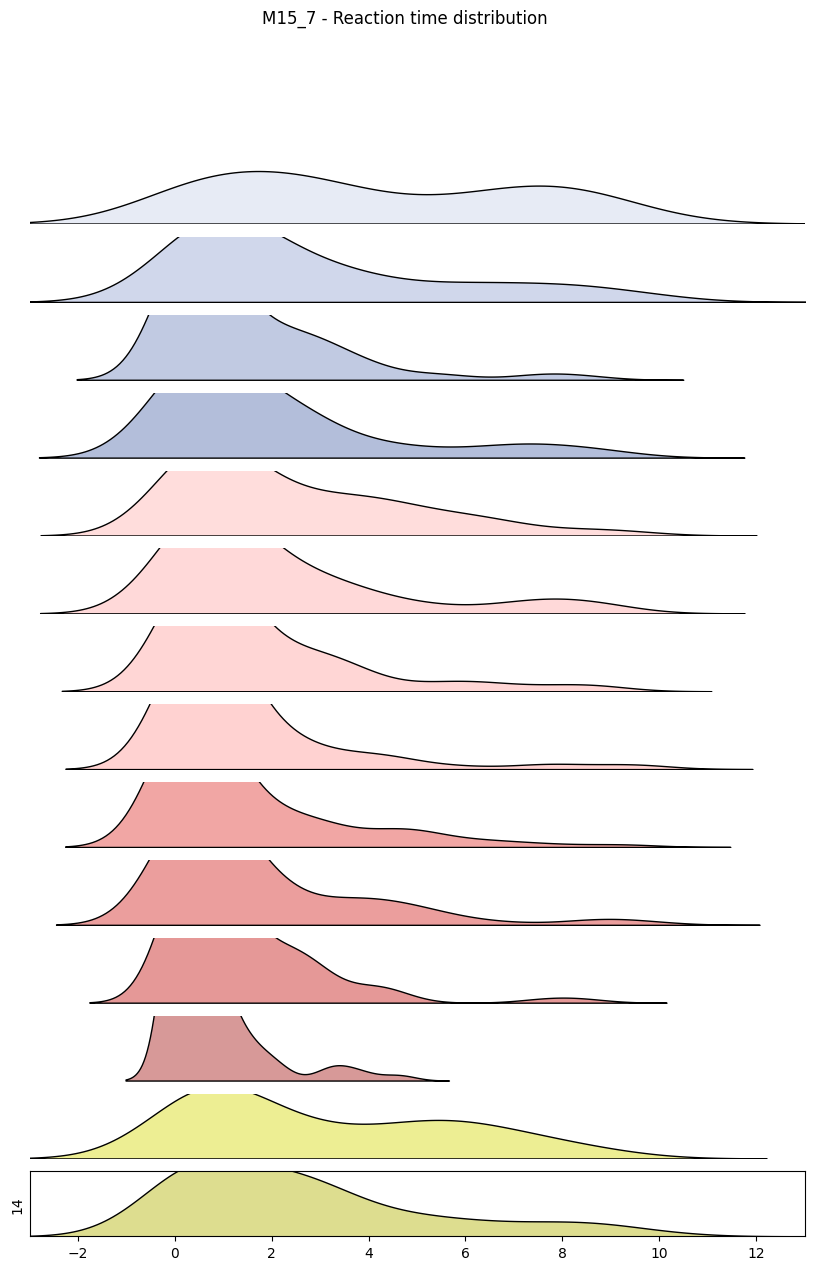

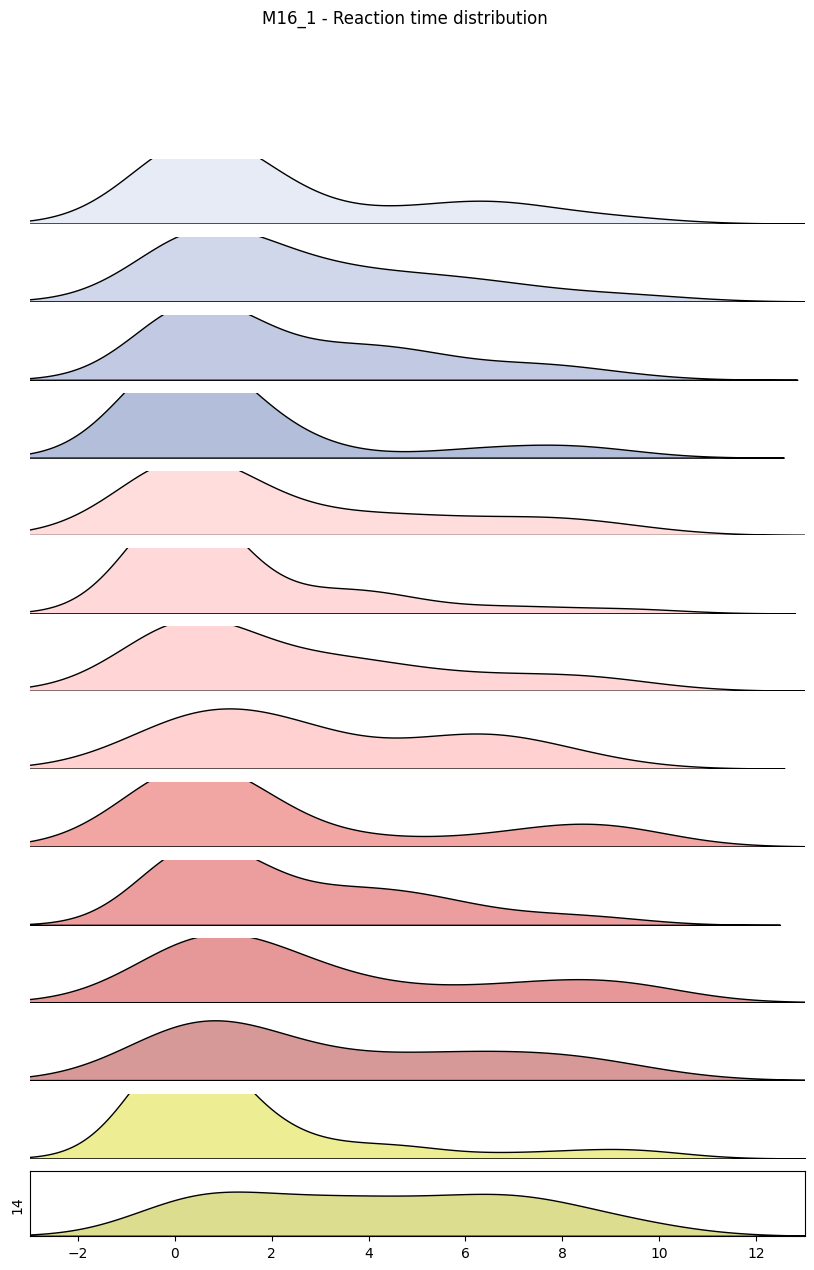

In [5]:
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    stats = reaction_times[reaction_times['subject']==subject]
    fig = plt.figure(figsize=(10, 15))
    for session in range(1, stats['session'].max()+1):
        ax = plt.subplot(len(stats['session'].unique())+1, 1, session)
        sns.kdeplot(data=stats[stats['session']==session], x='reaction', label=f'Session {session+1}', ax=ax, fill=True, color=session_palette[session],edgecolor='black', alpha=0.5)
        ax.set_ylim(0, 0.15)
        ax.set_xlim(-3, 13)
        ax.set_ylabel(session)
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_axis_off()
    ax.set_axis_on()
    fig.suptitle(f'{subject} - Reaction time distribution')
    plt.savefig(f'{figure_folder}/{subject}_reaction_density.pdf')
    plt.show()
    plt.close()

# Success Rate

In [6]:
import glob 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

joystick_length = 15
hw = 2048
n_s_per_min = 60
n_ms_per_s = 1000
joystick_threshold = 0.15
n_total_trial = 100

def analog_to_digital(analog, max_joystick_angle=22.5):
    return joystick_length * (np.sin(np.deg2rad(max_joystick_angle * analog/hw)))

half_successes = []
successes = []
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    session_paths = sorted(glob.glob(f'data/raw/controller/**/{subject.replace("_", "-")}.TXT'))
    for session_index, session_path in enumerate(session_paths):
        events = pd.read_csv(session_path)
        half_successes.append({
            'rate': events['s_trial'].tolist()[np.where(events['trial'] == (n_total_trial//2))[0][-1]]/(n_total_trial//2),
            'subject': subject,
            'session': session_index+1,
        })
        successes.append({
            'rate': events['s_trial'].tolist()[-1]/n_total_trial,
            'subject': subject,
            'session': session_index+1,
        })
half_successes = pd.json_normalize(half_successes)
successes = pd.json_normalize(successes)

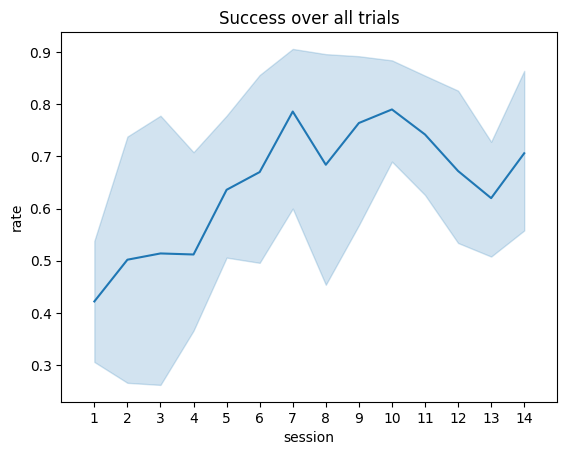

In [7]:
plt.figure()
sns.lineplot(data=successes, x='session', y='rate')#, hue='subject')
plt.title('Success over all trials')
plt.xlim(0, 15)
plt.xticks(np.arange(1, 15))
plt.savefig(f'{figure_folder}/rate_line.pdf')
plt.show()
plt.close()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 6: Welch's t-test independent samples, P_val:8.960e-02 t=-1.968e+00
1 vs. 10: Welch's t-test independent samples, P_val:3.782e-03 t=-4.134e+00
1 vs. 14: Welch's t-test independent samples, P_val:3.899e-02 t=-2.491e+00


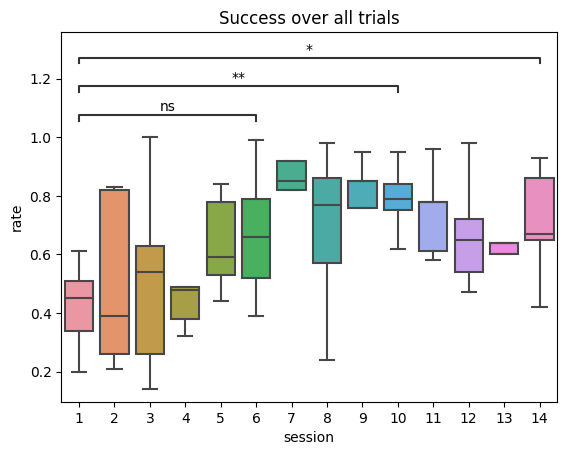

In [8]:
plt.figure()
ax = plt.gca()
sns.boxplot(data=successes, x='session', y='rate', showfliers=False, ax=ax)#, hue='subject')
plt.title('Success over all trials')
pairs = [(1, 6), (1, 10), (1, 14)]
annotator = Annotator(ax, pairs, data=successes, x='session', y='rate')
annotator.configure(test="t-test_welch").apply_and_annotate()
plt.savefig(f'{figure_folder}/rate_box.pdf')
plt.show()
plt.close()

# Unit by Session (Raster and PSTH)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spikeinterface.core as sc 
import spikeinterface.curation as scu
import spikeinterface.extractors as se

from tqdm.auto import tqdm 

n_segment = 14
plotted_units = {
    'main': {
        ('CA1', 'M16_1', 59): ('#667872', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [1, 4, 10]),
        ('CA1', 'M16_1', 33): ('#9f4854', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13], [1, 4, 10]),
        ('CA1', 'M16_1', 54): ('#da8430', [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13], [2, 4, 10]),
        ('M1', 'M15_3', 23): ('#a2b1d8', [0, 1, 3, 7, 8, 9, 10, 11, 12, 13], [0, 7, 13]),},
    'SI': {
        ('CA1', 'M16_1', 2): ('#9f4854', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13], [1, 7, 13]),
        ('CA1', 'M16_1', 8): ('#9f4854', [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13], [1, 8, 13]),
        ('CA1', 'M15_2', 36): ('#667872', np.arange(n_segment), [0, 7, 13]),
        ('M1', 'M15_7', 29): ('#667872', np.arange(n_segment), [0, 7, 13]),
        ('M1', 'M15_7', 46): ('#667872', np.arange(n_segment), [0, 7, 13]),
    },
}

n_ms_per_s = 1000
s_before, s_after = 1, 1
bin_size_ms = 200

for figure_group, group_plotted_units in plotted_units.items():
    for (region, subject, unit_id), (color, plotted_segments, psth_segments) in group_plotted_units.items():
        output_folder = f'{figure_folder}/raster-PSTH-{figure_group}/({bin_size_ms}ms)-success/{region}'
        os.makedirs(output_folder, exist_ok=True)
        unit_plot_file = f'{output_folder}/{subject}-{threshold}-{unit_id}.png'
        if os.path.isfile(unit_plot_file):
            continue

        session_info = pd.read_csv(f'data/processed/{subject}/info.csv')
            
        recordings = [sc.load_extractor(f'data/processed/{subject}/{region}/recordings/segment{segment_index}') for segment_index in range(n_segment)]
        recording = sc.concatenate_recordings(recordings)

        sorting = se.NpzSortingExtractor(f'data/processed/{subject}/{region}/sortings-{threshold}/sorter_output/firings.npz')
        sorting = scu.remove_excess_spikes(sorting, recording)
        sortings = sc.split_sorting(sorting, recordings)
        sortings = [sc.select_segment_sorting(sortings, segment_indices=segment) for segment in range(len(recordings))]

        n_frames_per_ms = int(sorting.sampling_frequency / n_ms_per_s)

        cue_spike_trains, cue_spike_bins, cue_train_counts = [], [], []
        
        for segment_index in plotted_segments:
            segment_info = session_info[session_info['segment_index'] == segment_index]

            controller_date = segment_info['segment_path'].item().split('_')[-2]
            controller_date = controller_date[2:] + controller_date[:2]
            controller_file = f'data/raw/controller/{controller_date}/{subject.replace("_", "-")}.TXT'
            events = pd.read_csv(controller_file)
            # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
            state_ids = np.where(events['state'] == 'state')[0]
            if len(state_ids) > 0:
                events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
                
            s_trials, f_trials = [], []
            reaction_times = {} # in ms
            for trial in range(n_total_trial):
                trial_indices = np.where(events['trial'] == trial)[0]
                if any(events['state'][trial_indices] == 1):
                    s_trials.append(trial)
                    # The first index having "triggered state" (1) and event trial number marks the reacted time.
                    reaction_time = events['time'].tolist()[np.where((events['state'] == 1) & (events['trial'] == trial))[0][0]]
                    # Off set the reaction time to the start of the trial.
                    reaction_time -= events['time'].tolist()[trial_indices.min()]
                    reaction_times[trial] = reaction_time / n_ms_per_s
                else:
                    f_trials.append(trial)
            assert len(s_trials) + len(f_trials) == n_total_trial
            
            trial_starts = eval(segment_info['trial_starts'].item())
            trial_ends = eval(segment_info['trial_ends'].item())

            unit_spike_train = sortings[segment_index].get_unit_spike_train(unit_id)

            segment_cue_spike_trains, segment_cue_spike_bins = [], []
            for trial, (trial_start, trial_end) in enumerate(zip(trial_starts, trial_ends)):
                if trial not in s_trials: continue

                t_cue_start = trial_start - s_before * sorting.sampling_frequency
                t_cue_end = trial_start + s_after * sorting.sampling_frequency

                cue_spike_train = unit_spike_train[(unit_spike_train >= t_cue_start) & (unit_spike_train <= t_cue_end)] - trial_start
                cue_spike_train = cue_spike_train / sorting.sampling_frequency
                segment_cue_spike_trains.append(cue_spike_train)

                cue_spike_bin = np.histogram(cue_spike_train, bins=np.arange(-s_before, s_after+1e-6, bin_size_ms/n_ms_per_s))[0]
                segment_cue_spike_bins.append(cue_spike_bin)
            segment_cue_spike_bins = np.array(segment_cue_spike_bins)
            segment_cue_spike_bins = segment_cue_spike_bins.mean(0)
            segment_cue_spike_bins -= segment_cue_spike_bins.min()
            
            cue_spike_trains.extend(segment_cue_spike_trains)
            cue_spike_bins.append(segment_cue_spike_bins)
            cue_train_counts.append(len(cue_spike_trains))

        cue_spike_bins = np.array(cue_spike_bins)
        cue_spike_bins = cue_spike_bins / cue_spike_bins.max()

        data = []
        for segment_index in range(cue_spike_bins.shape[0]):
            for time_index in range(cue_spike_bins.shape[1]):
                data.append({
                    'segment': segment_index+1,
                    'time': time_index,
                    'offsetted firing counts': cue_spike_bins[segment_index, time_index],
                })
        data = pd.json_normalize(data)

        ncol = 3
        fig = plt.figure(figsize=(7, 24))
        fig.suptitle(f'{subject} - {region} - {unit_id}')
        ax = plt.subplot(2, 2, 1)
        ax.eventplot(cue_spike_trains, colors=color)
        for segment_index, y in zip(plotted_segments, cue_train_counts):
            ax.axhline(y=y, color='black', linestyle='--', alpha=1, linewidth=0.5)
            ax.text(s_after+0.2, y, f'{segment_index+1}')
        ax.set_ylabel('trials')
        ax.set_title('relative to cue')
        ax.set_xticks([-1, 0, 1])

        for plot_index, (segment_index, segment_spike_bins) in enumerate(zip(plotted_segments, cue_spike_bins)):
            ax = plt.subplot(n_segment, ncol, ncol*(n_segment-(plot_index+1))+ncol)
            ax.plot(segment_spike_bins, color=color)
            ax.set_ylabel(segment_index+1)
            ax.set_xticks([0, 5, 10], [-1, 0, 1])
            ax.set_xlim(-2, 12)
            ax.set_ylim(0, cue_spike_bins.max())
            ax.set_yticks([0, 0.5])

        ax = plt.subplot(4, 2, 7)
        sns.lineplot(data=data, x='time', y='offsetted firing counts', ax=ax, color=color)

        plt.tight_layout()
        plt.savefig(unit_plot_file)#, transparent=True)
        # plt.show()
        plt.close()


        fig = plt.figure(figsize=(3, 10))
        fig.suptitle(f'{subject} - {region} - {unit_id}')
        ax = plt.gca()
        ax.eventplot(cue_spike_trains, colors=color)
        for segment_index, y in zip(plotted_segments, cue_train_counts):
            ax.axhline(y=y, color='black', linestyle='--', alpha=1, linewidth=0.5)
            ax.text(s_after+0.2, y, f'{segment_index+1}')
        ax.set_ylabel('trials')
        ax.set_title('relative to cue')
        ax.set_xticks([-1, 0, 1])
        ax.set_axis_off()
        plt.savefig(f'{output_folder}/{subject}-{threshold}-{unit_id}-raster.png', transparent=True)
        # plt.show()
        plt.close()

        fig = plt.figure(figsize=(2, 20))
        for plot_index, (segment_index, segment_spike_bins) in enumerate(zip(plotted_segments, cue_spike_bins)):
            ax = plt.subplot(len(plotted_segments), 1, plot_index+1)
            ax.plot(segment_spike_bins, color=color)
            ax.set_ylabel(segment_index+1)
            ax.set_xticks([0, 4.5, 9], [-1, 0, 1])
            ax.set_xlim(-2, 12)
            ax.set_ylim(0, cue_spike_bins.max())
            ax.set_yticks([0, 0.5])
        plt.tight_layout()
        plt.savefig(f'{output_folder}/{subject}-{threshold}-{unit_id}-PSTH.pdf')
        # plt.show()
        plt.close()

        fig = plt.figure(figsize=(3, 3))
        ax = plt.gca()
        for plot_index, (segment_index, segment_spike_bins) in enumerate(zip(plotted_segments, cue_spike_bins)):
            if segment_index in psth_segments:
                ax.plot(segment_spike_bins, color=color, alpha=min(1, 0.42+0.58*plot_index/10))
        ax.plot(cue_spike_bins.mean(0), color='gray', linestyle='--')
        ax.set_xticks([0, 4.5, 9], [-1, 0, 1])
        ax.set_ylim(0, 1)
        plt.tight_layout()
        plt.savefig(f'{output_folder}/{subject}-{threshold}-{unit_id}-PSTH-summary.pdf')
        # plt.show()
        plt.close()

/tmp/ipykernel_195247/1842411870.py:159: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/tmp/ipykernel_195247/1842411870.py:159: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/tmp/ipykernel_195247/1842411870.py:159: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/tmp/ipykernel_195247/1842411870.py:159: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/tmp/ipykernel_195247/1842411870.py:159: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/tmp/ipykernel_195247/1842411870.py:159: UserWarning: tight_layout not applied: number of columns in subp

# Ramp Classification

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import spikeinterface.core as sc 
import spikeinterface.curation as scu
import spikeinterface.extractors as se

from tqdm.auto import tqdm 

n_segment = 14
n_ms_per_s = 1000
s_before, s_after = 1, 1

for subject, subject_curation in curation.items():
    session_info = pd.read_csv(f'data/processed/{subject}/info.csv')
    
    subject_spike_trains = {}
    subject_spike_trains_file = f'{figure_folder}/{subject}_spike_trains_all.pickle'
    if not os.path.isfile(subject_spike_trains_file):
        for region, (threshold, curated_units) in subject_curation.items():
            
            recordings = [sc.load_extractor(f'data/processed/{subject}/{region}/recordings/segment{segment_index}') for segment_index in range(n_segment)]
            recording = sc.concatenate_recordings(recordings)

            sorting = se.NpzSortingExtractor(f'data/processed/{subject}/{region}/sortings-{threshold}/sorter_output/firings.npz')
            sorting = scu.remove_excess_spikes(sorting, recording)
            sortings = sc.split_sorting(sorting, recordings)
            sortings = [sc.select_segment_sorting(sortings, segment_indices=segment) for segment in range(len(recordings))]

            n_frames_per_ms = int(sorting.sampling_frequency / n_ms_per_s)

            for unit_id in tqdm(curated_units):        
                cue_spike_trains = []
                
                for segment_index in range(n_segment):
                    segment_info = session_info[session_info['segment_index'] == segment_index]

                    trial_starts = eval(segment_info['trial_starts'].item())
                    trial_ends = eval(segment_info['trial_ends'].item())

                    unit_spike_train = sortings[segment_index].get_unit_spike_train(unit_id)

                    segment_cue_spike_trains = []
                    for trial, (trial_start, trial_end) in enumerate(zip(trial_starts, trial_ends)):

                        t_cue_start = trial_start - s_before * sorting.sampling_frequency
                        t_cue_end = trial_start + s_after * sorting.sampling_frequency

                        cue_spike_train = unit_spike_train[(unit_spike_train >= t_cue_start) & (unit_spike_train <= t_cue_end)] - trial_start
                        cue_spike_train = cue_spike_train / sorting.sampling_frequency
                        segment_cue_spike_trains.append(cue_spike_train)

                    cue_spike_trains.append(segment_cue_spike_trains)
                
                subject_spike_trains[(region, unit_id)] = cue_spike_trains
        with open(subject_spike_trains_file, 'wb') as file:
            pickle.dump(subject_spike_trains, file)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

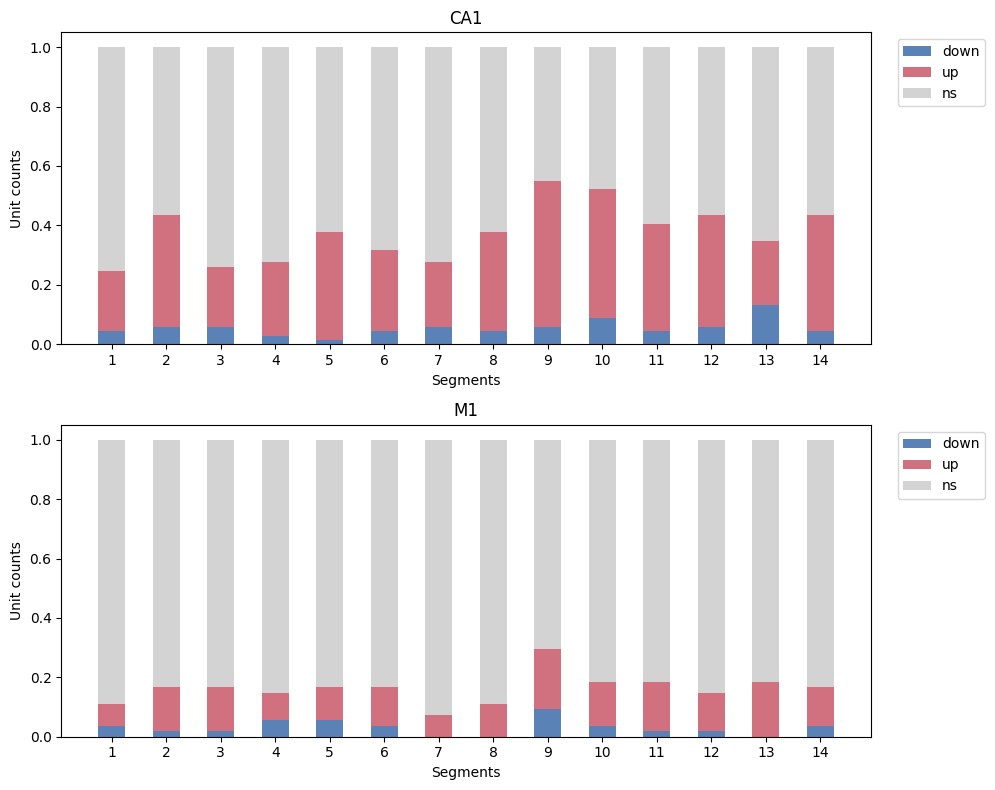

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import spikeinterface.core as sc 
import spikeinterface.curation as scu
import spikeinterface.extractors as se
import statsmodels.api as sm

from tqdm.auto import tqdm 

bin_size_ms = 10

unit_classifications = []
for subject, subject_curation in curation.items():
    session_info = pd.read_csv(f'data/processed/{subject}/info.csv')
    subject_spike_trains = pickle.load(open(f'{figure_folder}/{subject}_spike_trains_all.pickle', 'rb'))

    subject_s_trials = {}
    for (region, unit_id), cue_spike_trains in tqdm(subject_spike_trains.items()):

        cue_spike_bins = []
        for segment_index, segment_spike_trains in enumerate(cue_spike_trains): 
            if segment_index not in subject_s_trials:
                segment_info = session_info[session_info['segment_index'] == segment_index]

                controller_date = segment_info['segment_path'].item().split('_')[-2]
                controller_date = controller_date[2:] + controller_date[:2]
                controller_file = f'data/raw/controller/{controller_date}/{subject.replace("_", "-")}.TXT'
                events = pd.read_csv(controller_file)
                # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
                state_ids = np.where(events['state'] == 'state')[0]
                if len(state_ids) > 0:
                    events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
                    
                s_trials, f_trials = [], []
                reaction_times = {}
        
                s_trials, f_trials = [], []
                reaction_times = {} # in ms
                for trial in range(n_total_trial):
                    trial_indices = np.where(events['trial'] == trial)[0]
                    if any(events['state'][trial_indices] == 1):
                        s_trials.append(trial)
                        # The first index having "triggered state" (1) and event trial number marks the reacted time.
                        reaction_time = events['time'].tolist()[np.where((events['state'] == 1) & (events['trial'] == trial))[0][0]]
                        # Off set the reaction time to the start of the trial.
                        reaction_time -= events['time'].tolist()[trial_indices.min()]
                        reaction_times[trial] = reaction_time / n_ms_per_s
                    else:
                        f_trials.append(trial)
                assert len(s_trials) + len(f_trials) == n_total_trial

                subject_s_trials[segment_index] = s_trials
            
            segment_spike_bins = []
            for trial, cue_spike_train in enumerate(segment_spike_trains):       
                if trial not in subject_s_trials[segment_index]: continue         
                cue_spike_bin = np.histogram(cue_spike_train, bins=np.arange(-s_before, s_after+1e-6, bin_size_ms/n_ms_per_s))[0]

                segment_spike_bins.append(cue_spike_bin)
            segment_spike_bins = np.array(segment_spike_bins)
            cue_spike_bins.append(segment_spike_bins)

        for segment_index, segment_spike_bins in enumerate(cue_spike_bins):
            mean_spike_bin = segment_spike_bins.mean(0)

            assert len(mean_spike_bin) % 2 == 0
            mean_spike_bin = mean_spike_bin[len(mean_spike_bin)//2-10:len(mean_spike_bin)//2+10]

            indices = np.arange(len(mean_spike_bin))
            X = sm.add_constant(indices)
            model = sm.OLS(mean_spike_bin, X).fit()

            slope = model.params[1]
            p_value = model.pvalues[1]
            significant = p_value < 0.05

            if significant: 
                label = 'up' if slope > 0 else 'down'
            else:
                label = 'ns'

            unit_classifications.append({
                'subject': subject,
                'region': region,
                'unit_id': unit_id,
                'segment_index': segment_index,
                'label': label,
            })


stats = pd.json_normalize(unit_classifications)


label_fractions = {}
for region in ['CA1', 'M1']: 
    region_stats = stats[stats['region'] == region]
    label_fractions[region] = {
        'up': [],
        'down': [],
        'ns': [],
    }
    for segment_index in range(n_segment):
        segment_stats = region_stats[region_stats['segment_index'] == segment_index]
        segment_counts = segment_stats['label'].value_counts()
        for label in label_fractions[region]:
            label_fractions[region][label].append(segment_counts.get(label, 0) / sum(segment_counts.values))


colors = {
    'ns': 'lightgray',
    'up': '#d1707e',
    'down': '#5a82b7',
}

# Sample data for the plot
segments = np.arange(n_segment)

# Function to create the stacked bar chart
def plot_stacked_bar(ax, x_labels, fractions, title):
    bar_width = 0.5
    index = np.arange(len(x_labels))
    bottom = np.zeros(len(x_labels))

    for category in ['down', 'up', 'ns']:
        ax.bar(index, fractions[category], bar_width, label=category, bottom=bottom, color=colors[category])
        bottom += np.array(fractions[category])

    ax.set_xlabel('Segments')
    ax.set_ylabel('Unit counts')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.15, 1))
    ax.set_xticks(np.arange(n_segment), np.arange(n_segment)+1)

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the data
plot_stacked_bar(ax1, segments, label_fractions['CA1'], 'CA1')
plot_stacked_bar(ax2, segments, label_fractions['M1'], 'M1')

plt.tight_layout()
plt.savefig(f'{figure_folder}/unit_classifications.pdf', transparent=True)
plt.show()
plt.close()
    

# Overall Heatmap

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

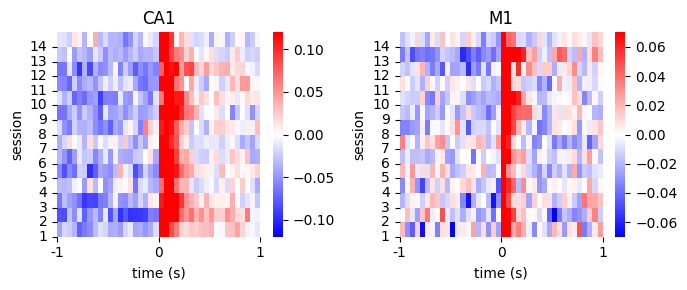

In [35]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import spikeinterface.core as sc 
import spikeinterface.curation as scu
import spikeinterface.extractors as se 

from tqdm.auto import tqdm

bin_size = 50
n_segment = 14
s_before_cue, s_after_cue = 1, 1

s_spike_trains = {}

all_s_trials = {}
for region in ['CA1', 'M1']:
    s_spike_trains[region] = {}

    for subject, subject_curation in curation.items():
        session_info = pd.read_csv(f'data/processed/{subject}/info.csv')
        subject_spike_trains = pickle.load(open(f'{figure_folder}/{subject}_spike_trains_all.pickle', 'rb'))
        
        for (cue_region, unit_id), cue_spike_trains in tqdm(subject_spike_trains.items()):
            if cue_region != region: continue

            for segment_index, segment_spike_trains in enumerate(cue_spike_trains): 
                if (subject, segment_index) not in all_s_trials:
                    segment_info = session_info[session_info['segment_index'] == segment_index]

                    controller_date = segment_info['segment_path'].item().split('_')[-2]
                    controller_date = controller_date[2:] + controller_date[:2]
                    controller_file = f'data/raw/controller/{controller_date}/{subject.replace("_", "-")}.TXT'
                    events = pd.read_csv(controller_file)
                    # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
                    state_ids = np.where(events['state'] == 'state')[0]
                    if len(state_ids) > 0:
                        events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
                        
                    s_trials, f_trials = [], []
                    reaction_times = {}
            
                    s_trials, f_trials = [], []
                    reaction_times = {} # in ms
                    for trial in range(n_total_trial):
                        trial_indices = np.where(events['trial'] == trial)[0]
                        if any(events['state'][trial_indices] == 1):
                            s_trials.append(trial)
                            # The first index having "triggered state" (1) and event trial number marks the reacted time.
                            reaction_time = events['time'].tolist()[np.where((events['state'] == 1) & (events['trial'] == trial))[0][0]]
                            # Off set the reaction time to the start of the trial.
                            reaction_time -= events['time'].tolist()[trial_indices.min()]
                            reaction_times[trial] = reaction_time / n_ms_per_s
                        else:
                            f_trials.append(trial)
                    assert len(s_trials) + len(f_trials) == n_total_trial

                    all_s_trials[(subject, segment_index)] = s_trials
                
                segment_s_spike_trains = s_spike_trains[region].get(segment_index, {})
                segment_s_spike_trains[(subject, unit_id)] = []
                for trial, cue_spike_train in enumerate(segment_spike_trains):
                    if trial not in all_s_trials[(subject, segment_index)]: continue
                    segment_s_spike_trains[(subject, unit_id)].append(cue_spike_train)
                    
                s_spike_trains[region][segment_index] = segment_s_spike_trains

spike_bins = {}
for region, region_spike_trains in s_spike_trains.items():
    spike_bins[region] = []
    for segment_index in range(n_segment):
        segment_spike_bins = []
        for unit_id, unit_spike_trains in region_spike_trains[segment_index].items():
            unit_bins = []
            for trial_spike_train in unit_spike_trains:
                unit_bins.append(np.histogram(trial_spike_train, bins=np.arange(-s_before_cue, s_after_cue+1e-6, bin_size/n_ms_per_s))[0])
            unit_bins = np.array(unit_bins)
            unit_bins = (unit_bins - unit_bins.mean()) / (unit_bins.std() + 1e-6)
            segment_spike_bins.append(unit_bins.mean(0))
        mean_spike_bins = np.array(segment_spike_bins).mean(0)
        spike_bins[region].append(mean_spike_bins)
    spike_bins[region] = np.array(spike_bins[region])


vlims = { 'CA1': 0.12, 'M1': 0.07 }
plt.figure(figsize=(7, 3))
for plot_index, (region, region_spike_bins) in enumerate(spike_bins.items()):
    ax = plt.subplot(1, len(spike_bins), plot_index + 1)
    sns.heatmap(spike_bins[region], ax = ax, cmap=plt.cm.bwr, vmin=-vlims[region], vmax=vlims[region])
    ax.set_title(region)
    ax.set_xticks([0, spike_bins[region].shape[1] // 2, spike_bins[region].shape[1]], [-1, 0, 1], rotation=0)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('session')
    ax.set_yticks(np.arange(n_segment), np.arange(n_segment)+1)
    ax.invert_yaxis()
plt.savefig(f'{figure_folder}/heatmap_{bin_size}ms.pdf')
plt.tight_layout()
plt.show()

In [37]:
import numpy as np
import pandas as pd
import pickle
import spikeinterface.core as sc 
import spikeinterface.curation as scu
import spikeinterface.extractors as se

from tqdm.auto import tqdm 

n_segment = 14
n_ms_per_s = 1000
s_before, s_after = 1, 1
bin_size_ms = 100

densities = {}
for subject, subject_curation in curation.items():
    session_info = pd.read_csv(f'data/processed/{subject}/info.csv')
    
    subject_s_trials = {}
    for region, (threshold, curated_units) in subject_curation.items():
        recordings = [sc.load_extractor(f'data/processed/{subject}/{region}/recordings/segment{segment_index}') for segment_index in range(n_segment)]
        recording = sc.concatenate_recordings(recordings)

        sorting = se.NpzSortingExtractor(f'data/processed/{subject}/{region}/sortings-{threshold}/sorter_output/firings.npz')
        sorting = scu.remove_excess_spikes(sorting, recording)
        sortings = sc.split_sorting(sorting, recordings)
        sortings = [sc.select_segment_sorting(sortings, segment_indices=segment) for segment in range(len(recordings))]

        n_frames_per_ms = int(sorting.sampling_frequency / n_ms_per_s)

        for unit_id in tqdm(curated_units):        
            spike_bins = []
        
            for segment_index in range(n_segment):
                segment_info = session_info[session_info['segment_index'] == segment_index]

                controller_date = segment_info['segment_path'].item().split('_')[-2]
                controller_date = controller_date[2:] + controller_date[:2]
                controller_file = f'data/raw/controller/{controller_date}/{subject.replace("_", "-")}.TXT'
                events = pd.read_csv(controller_file)
                # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
                state_ids = np.where(events['state'] == 'state')[0]
                if len(state_ids) > 0:
                    events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
                    
                s_trials, f_trials = [], []
                reaction_times = {} # in ms
                for trial in range(n_total_trial):
                    trial_indices = np.where(events['trial'] == trial)[0]
                    if any(events['state'][trial_indices] == 1):
                        s_trials.append(trial)
                        # The first index having "triggered state" (1) and event trial number marks the reacted time.
                        reaction_time = events['time'].tolist()[np.where((events['state'] == 1) & (events['trial'] == trial))[0][0]]
                        # Off set the reaction time to the start of the trial.
                        reaction_time -= events['time'].tolist()[trial_indices.min()]
                        reaction_times[trial] = reaction_time / n_ms_per_s
                    else:
                        f_trials.append(trial)
                assert len(s_trials) + len(f_trials) == n_total_trial
                
                trial_starts = eval(segment_info['trial_starts'].item())
                trial_ends = eval(segment_info['trial_ends'].item())

                unit_spike_train = sortings[segment_index].get_unit_spike_train(unit_id)

                segment_cue_spike_bins, segment_reward_spike_bins = [], []
                for trial, (trial_start, trial_end) in enumerate(zip(trial_starts, trial_ends)):
                    # In this plots only successful trials have reaction time.
                    if trial not in s_trials: continue

                    t_cue_start = trial_start - s_before * sorting.sampling_frequency
                    t_cue_end = trial_start + s_after * sorting.sampling_frequency

                    cue_spike_train = unit_spike_train[(unit_spike_train >= t_cue_start) & (unit_spike_train <= t_cue_end)] - trial_start
                    cue_spike_train = cue_spike_train / sorting.sampling_frequency
                    cue_spike_bin = np.histogram(cue_spike_train, bins=np.arange(-s_before, s_after+1e-6, bin_size_ms/n_ms_per_s))[0]
                    segment_cue_spike_bins.append(cue_spike_bin)

                    reward_time = int(trial_start + (reaction_times[trial] + 1) * sorting.sampling_frequency)
                    t_reward_start = reward_time # - s_before * sorting.sampling_frequency
                    t_reward_end = reward_time + (s_before + s_after) * sorting.sampling_frequency

                    reward_spike_train = unit_spike_train[(unit_spike_train >= t_reward_start) & (unit_spike_train <= t_reward_end)] - reward_time
                    reward_spike_train = reward_spike_train / sorting.sampling_frequency
                    reward_spike_bin = np.histogram(reward_spike_train, bins=np.arange(0, (s_before + s_after)+1e-6, bin_size_ms/n_ms_per_s))[0]
                    segment_reward_spike_bins.append(reward_spike_bin)
                
                segment_cue_spike_bins = np.array(segment_cue_spike_bins)
                segment_reward_spike_bins = np.array(segment_reward_spike_bins)

                segment_bins = np.hstack([segment_cue_spike_bins, segment_reward_spike_bins])
                segment_bins = (segment_bins - segment_bins.mean()) / (segment_bins.std() + 1e-6)

                spike_bins.append(segment_bins.mean(0))
            
            spike_bins = np.array(spike_bins)
            cue_spike_bins = spike_bins[:, :spike_bins.shape[1] // 2]
            reward_spike_bins = spike_bins[:, spike_bins.shape[1] // 2:]

            densities[(subject, region, unit_id)] = {
                'cue': cue_spike_bins,
                'reward': reward_spike_bins,
            }
            
# Open a file in write mode
with open(f'{figure_folder}/densities.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(densities, file)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

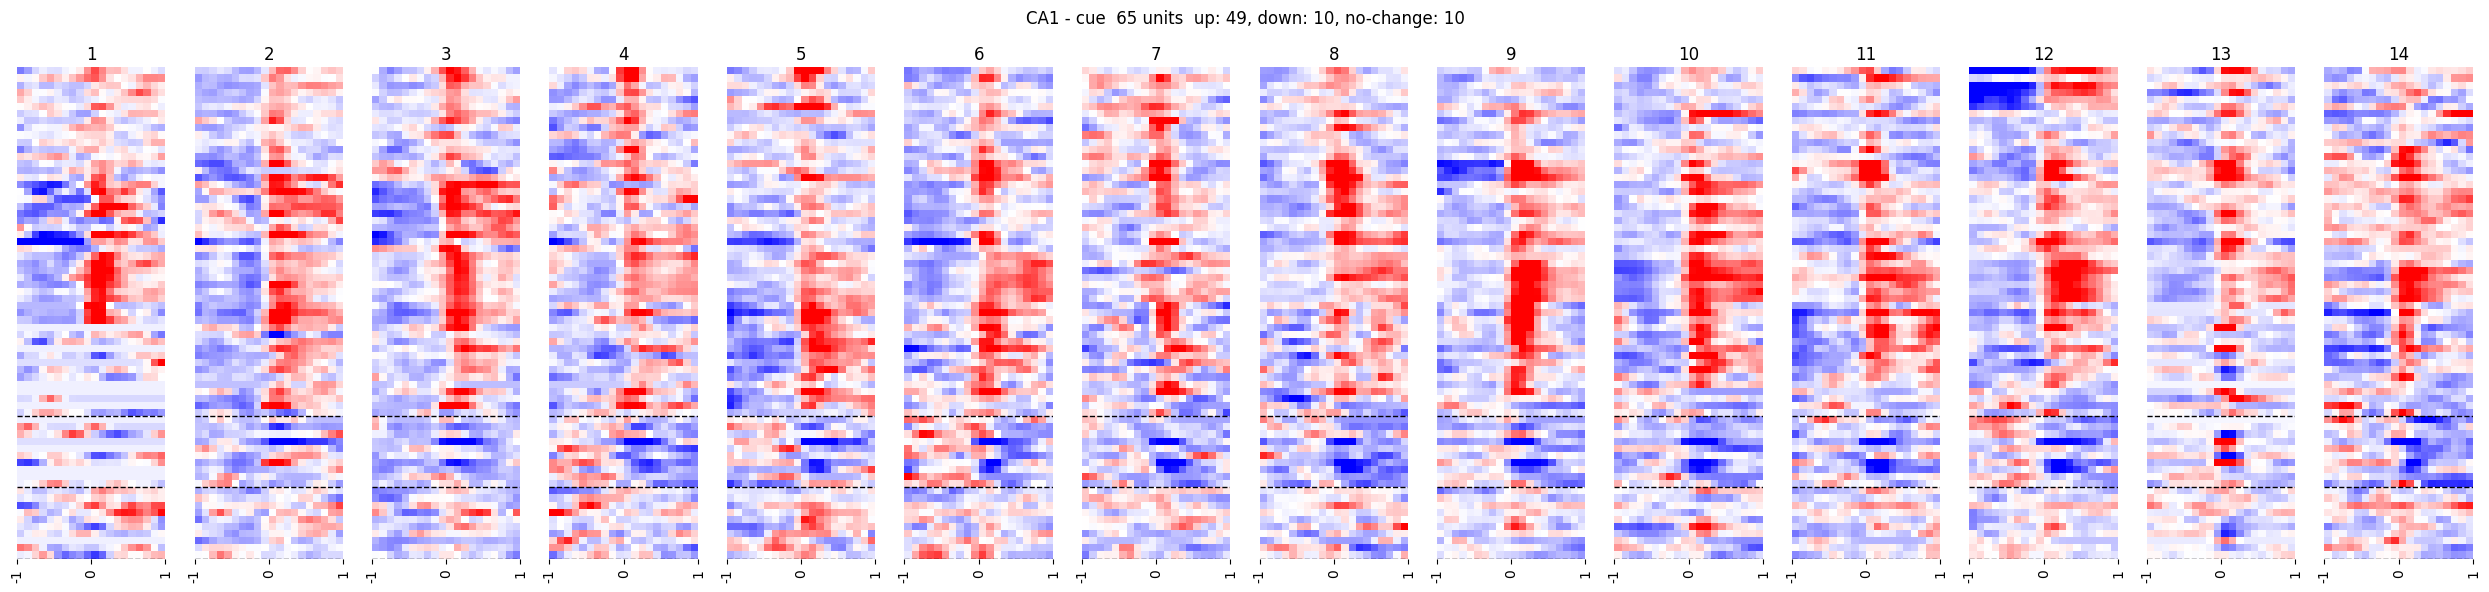

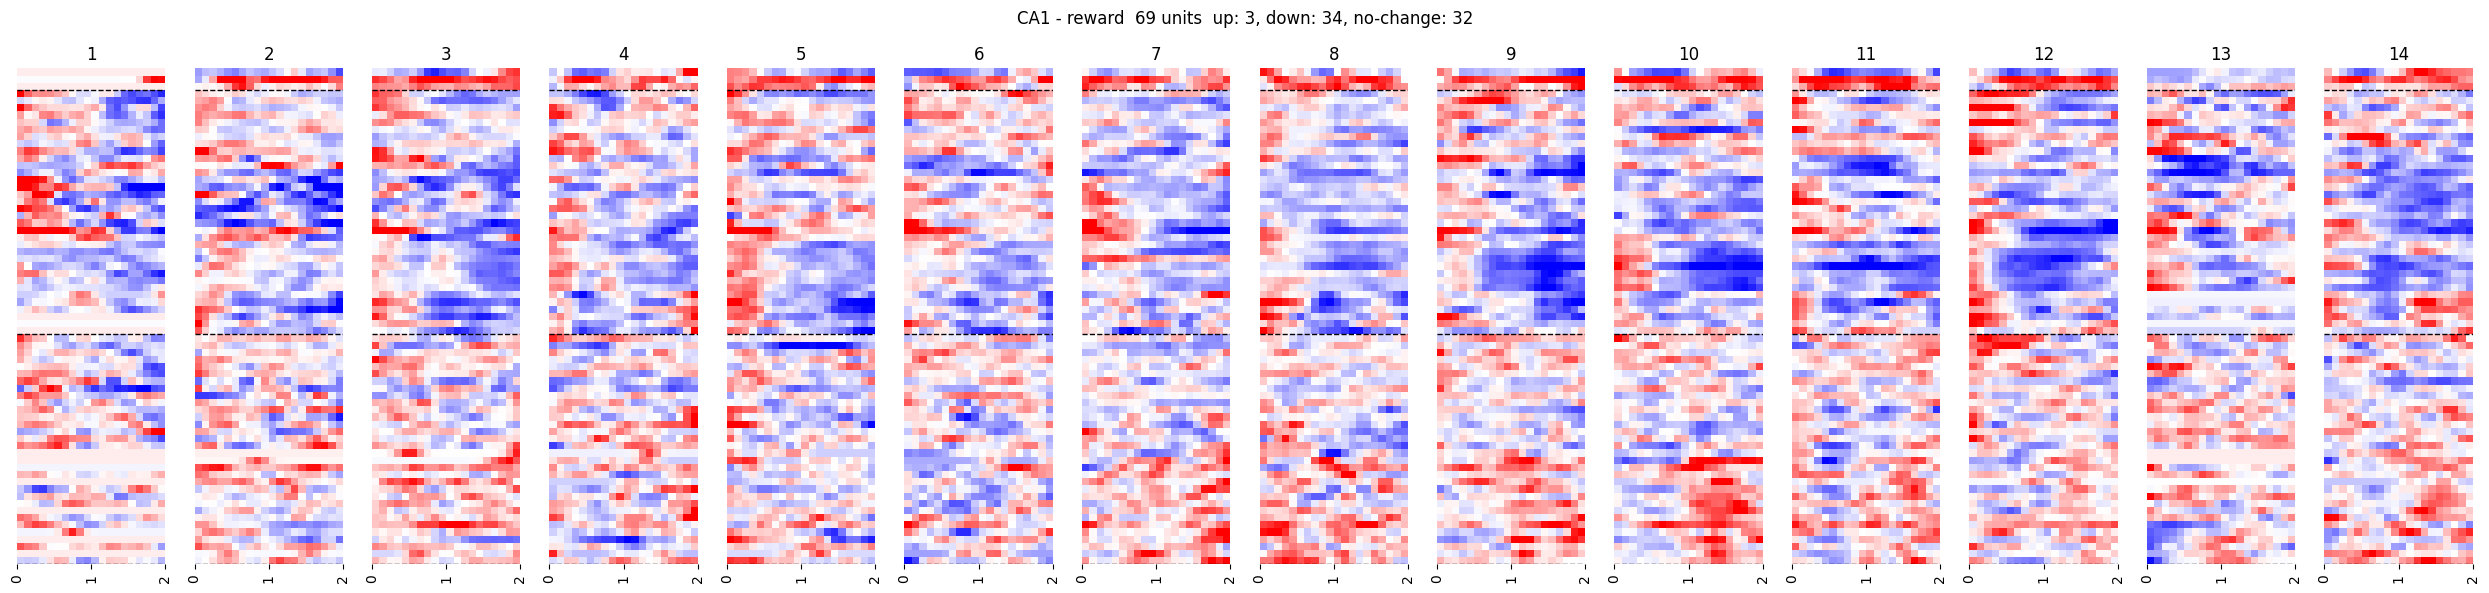

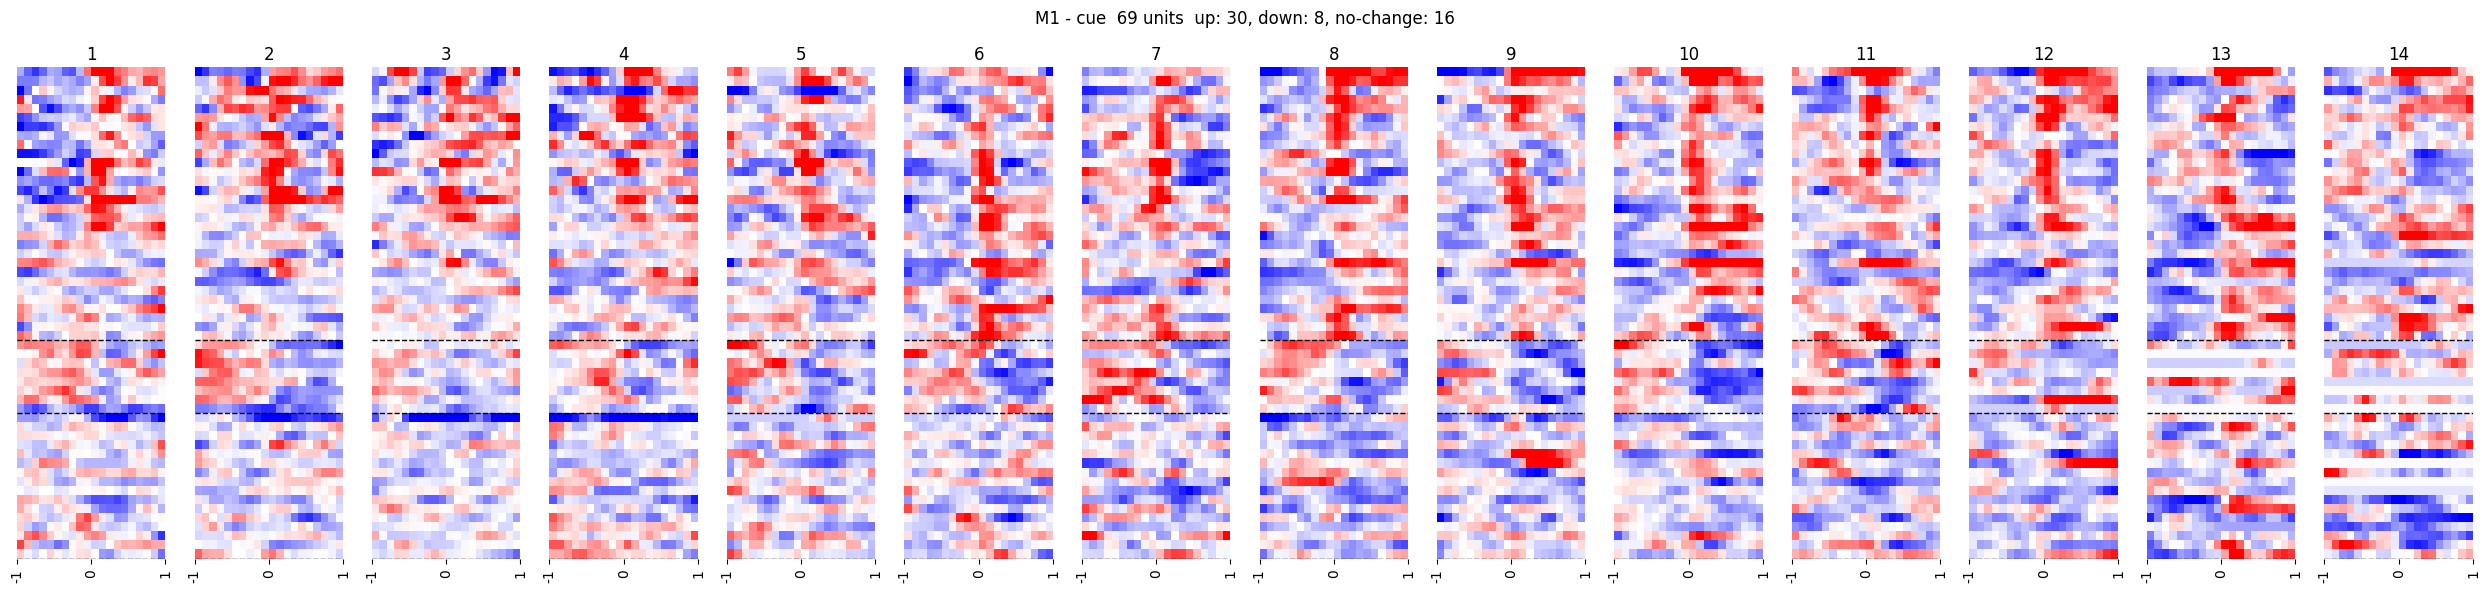

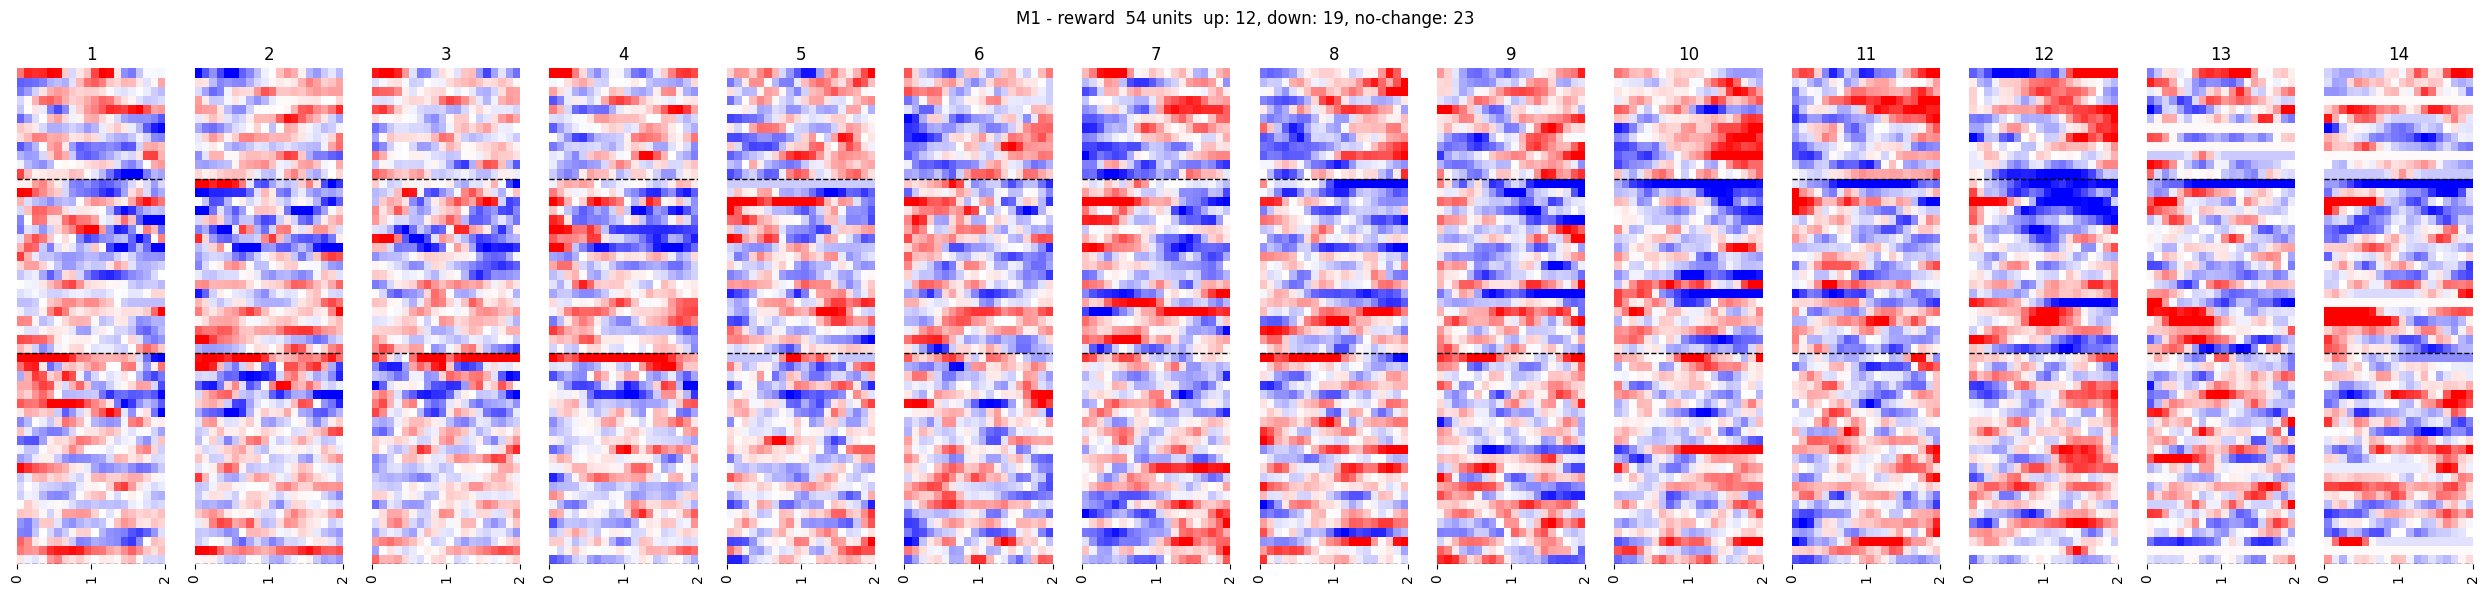

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns

from scipy.ndimage import gaussian_filter1d

react_units = {
    'cue':{
        'CA1': {
            'up': {
                'M15_2': [1, 10, 11, 13, 15, 24, 29, 44, 45, 48, 6, 7, 9],
                'M15_3': [25, 29, 34],
                'M15_5': [11, 12, 15, 21, 4, 5, 62, 66, 7, 9],
                'M15_7': [11, 12, 13, 14, 19, 20, 7],
                'M16_1': [1, 10, 11, 13, 14, 2, 3, 36, 5, 57, 59, 6, 60, 7, 8, 9],
            },
            'down': {
                'M15_2': [],
                'M15_3': [],
                'M15_5': [],
                'M15_7': [],
                'M16_1': [25, 26, 32, 33, 37, 38, 54, 58, 61, 62],
            },
        },
        'M1': {
            'up': {
                'M15_2': [],
                'M15_3': [23],
                'M15_5': [28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44],
                'M15_7': [10, 17, 18, 19, 21, 30, 37, 4, 41, 46, 48, 51, 53, 57, 6],
                'M16_1': [],
            },
            'down': {
                'M15_2': [],
                'M15_3': [],
                'M15_5': [],
                'M15_7': [42, 44, 45, 52, 55, 56, 58, 59],
                'M16_1': [],
            },
        },
    },
    'reward': {
        'CA1': {
            'up': {
                'M15_2': [],
                'M15_3': [],
                'M15_5': [],
                'M15_7': [],
                'M16_1': [33, 5, 58],
            },
            'down': {
                'M15_2': [1, 13, 15, 24, 48, 6, 7, 8, 9],
                'M15_3': [25, 29, 34],
                'M15_5': [11, 15, 21, 4, 5, 62, 66, 8, 9],
                'M15_7': [11, 12, 13, 14, 19, 20, 7],
                'M16_1': [1, 10, 2, 3, 36, 8],
            },
        },
        'M1': {
            'up': {
                'M15_2': [],
                'M15_3': [],
                'M15_5': [38], 
                'M15_7': [14, 15, 24, 30, 36, 42, 44, 51, 52, 56, 57, 58],
                'M16_1': [],
            },
            'down': {
                'M15_2': [],
                'M15_3': [23],
                'M15_5': [28, 29, 31, 33, 34, 40, 44],
                'M15_7': [10, 19, 21, 22, 29, 32, 37, 4, 41, 53, 6],
                'M16_1': [],
            },
        },
    },
}

# Open the file in read mode
with open(f'{figure_folder}/densities.pickle', 'rb') as file:
    # Deserialize and load the object from the file
    loaded_densities = pickle.load(file)

vlims = {
    'CA1': 1.8,
    'M1': 1.5,
}
n_segment = 14
conditions = ['cue', 'reward']

for plot_region in ['CA1', 'M1']:
    for condition in conditions:    
        typed_bins = {
            'up': [],
            'down': [],
            'no-change': [],
        }
        for (subject, region, unit_id), bins in loaded_densities.items():
            if region != plot_region: continue
            if unit_id in react_units[condition][region]['up'][subject]:
                label = 'up'
            elif unit_id in react_units[condition][region]['down'][subject]:
                label = 'down'
            else:
                label = 'no-change'
            typed_bins[label].append(bins[condition]) 

        unit_counts = [0]
        for label, label_bins in typed_bins.items():
            unit_counts.append(unit_counts[-1] + len(label_bins))
        unit_counts = unit_counts[1:]

        fig = plt.figure(figsize=(25, 6))
        fig.suptitle(f'{plot_region} - {condition}  {len(segment_bins)} units  ' + ', '.join([f'{label}: {len(label_bins)}' for label, label_bins in typed_bins.items()]))
        for segment_index in range(n_segment):
            ax = plt.subplot(1, n_segment, segment_index+1)  
            segment_bins = []
            for label, label_bins in typed_bins.items():
                segment_bins.append(np.array(label_bins)[:, segment_index])
            segment_bins = np.vstack(segment_bins)
            segment_bins = (segment_bins - segment_bins.mean()) / (segment_bins.std() + 1e-6)
            segment_bins = gaussian_filter1d(segment_bins, 1)
            sns.heatmap(segment_bins, cmap=plt.cm.bwr, ax=ax, vmin=-vlims[plot_region], vmax=vlims[plot_region], cbar=False)
            ax.set_yticks([])
            for type_index, y in enumerate(unit_counts):
                ax.axhline(y=y, color='black', linestyle='--', alpha=1, linewidth=1)

            ax.set_title(f'{segment_index+1}')
            ax.set_xticks([0, 10, 20], [-1, 0, 1] if condition == 'cue' else [0, 1, 2])
        plt.tight_layout()
        plt.savefig(f'{figure_folder}/{plot_region}-{condition}_heatmap.pdf')
        plt.show() 
        plt.close()